<a href="https://colab.research.google.com/github/AlenaAntipina/KungfuGameDetector/blob/main/RL_ITMO_AUTOANOTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install --upgrade gym 
!pip3 install box2d-py
!pip3 install gym[All]
!pip install gym[atari,accept-rom-license]==0.21.0
!pip install --ignore-installed Pillow==9.0.0
from google.colab import output
output.clear()

# Перезагружаем среду выполнения

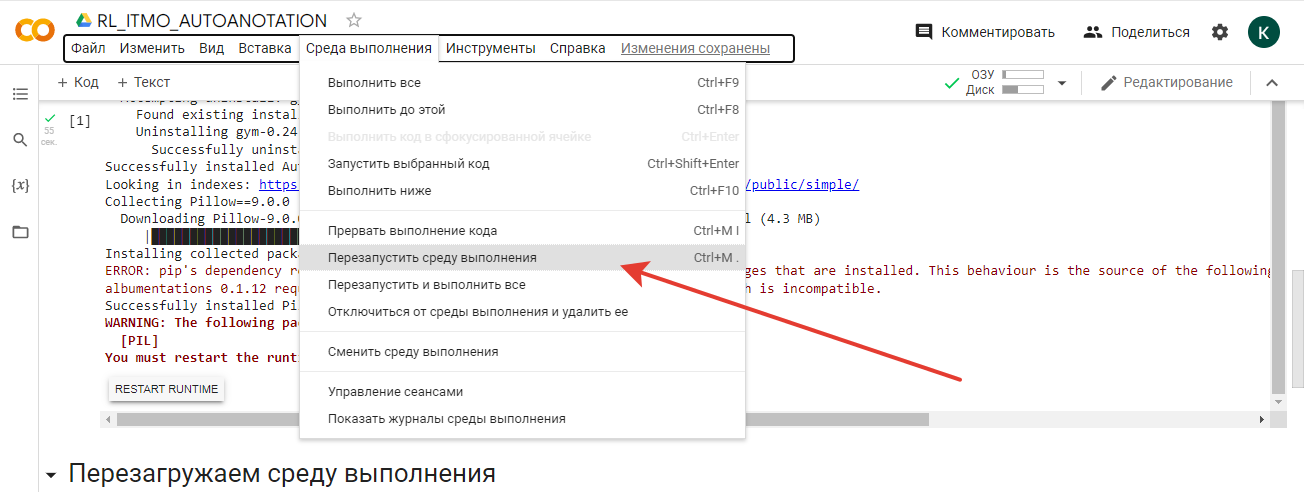

In [ ]:
import os
import sys

if "google.colab" in sys.modules and not os.path.exists(".setup_complete"):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    #!wget -q https://raw.githubusercontent.com/girafe-ai/ml-mipt/develop_advanced_practice/homeworks_advanced/Lab2_RL/atari_util.py
    #!wget -q https://raw.githubusercontent.com/girafe-ai/ml-mipt/develop_advanced_practice/homeworks_advanced/Lab2_RL/env_pool.py
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ["DISPLAY"] = ":1"

Selecting previously unselected package xvfb.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary
from matplotlib.patches import Rectangle
#from pushover import notify
#from utils import makegif
from random import randint

from IPython.display import Image
import matplotlib.pyplot as plt
from IPython.core.display import Image, display
from tqdm.notebook import trange
from google.colab import output

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Создаём среду

In [ ]:
import gym
env = gym.make("KungFuMasterDeterministic-v0")

In [ ]:
env.reset()
for i in range(90): # пропускаем первые тики игры
    n_state, reward, done, info = env.step(env.action_space.sample())

In [ ]:
obs_shape = env.render('rgb_array')[100:164,26:154,:].shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", {i:j for i,j in zip(range(14), env.env.get_action_meanings())})

Observation shape: (64, 128, 3)
Num actions: 14
Action names: {0: 'NOOP', 1: 'UP', 2: 'RIGHT', 3: 'LEFT', 4: 'DOWN', 5: 'DOWNRIGHT', 6: 'DOWNLEFT', 7: 'RIGHTFIRE', 8: 'LEFTFIRE', 9: 'DOWNFIRE', 10: 'UPRIGHTFIRE', 11: 'UPLEFTFIRE', 12: 'DOWNRIGHTFIRE', 13: 'DOWNLEFTFIRE'}


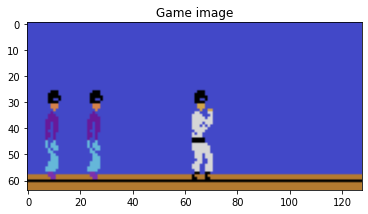

In [ ]:
n_state, reward, done, info = env.step(0) # можем вводить команды от 0 до 13
plt.title('Game image')
plt.imshow(env.render('rgb_array')[100:164,26:154,:])
plt.show()

Выводим изображение

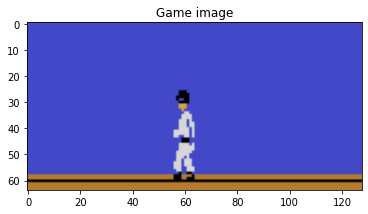

In [ ]:
plt.title('Game image')
plt.imshow(env.render('rgb_array')[100:164,26:154,:])
plt.show()

Функции для детекции героя, противников и пуль

In [ ]:
def show_result(name, color, x_ugl, y_ugl, weight, heigh):
    plt.gca().add_patch(Rectangle( (x_ugl,y_ugl), weight, heigh, linewidth=1, edgecolor=color, facecolor='none'))
    plt.text(x_ugl, y_ugl-3, name, fontsize=20, color=color)


def show_npc(render, show=True):
    temp = (render.sum(axis=2)==283).astype(float)
    y_ugl, heigh = 25, 34
    list_coord = []
    flag= False
    if temp.sum():
        flag = True
        temp1 = temp.sum(0)!=0
        list_point = []
        point1, point2, flag = 0, 0, False
        n = len(temp1)
        for i in range(1, n):
            if temp1[i-1] and not flag:
                point1, point2, flag= i-1, 1, True
            if temp1[i-1] and temp1[i]:
                point2+=1
            if temp1[i-1] and not temp1[i] or temp1[i] and i==n-1:
                if point2>4:
                    list_point.append((point1, point2))
                flag = False
        for i in list_point:
            x_ugl = i[0] - 1.5
            weight =  i[1] + 2.5
            list_coord.append((0, (x_ugl+weight/2)/render.shape[1], 
                                    (y_ugl+heigh/2)/render.shape[0], 
                                    weight/render.shape[1], 
                                    heigh/render.shape[0]))
            show_result('NPC', 'tab:pink', x_ugl, y_ugl, weight, heigh)
    temp = (render.sum(axis=2)==576).astype(float)
    if temp.sum():
        flag = True
        temp1 = temp.sum(0)!=0
        x_ugl = temp1.argmax() - 1.5
        weight = temp1.sum() + 2
        list_coord.append((0, (x_ugl+weight/2)/render.shape[1], 
                           (y_ugl+heigh/2)/render.shape[0], 
                           weight/render.shape[1], 
                           heigh/render.shape[0]))
        if show:
            show_result('NPC', 'tab:pink', x_ugl, y_ugl, weight, heigh)
    if flag:
        return True, list_coord
    return False, (0, 0, 0, 0, 0)

def show_hero(render, show=True):
    temp = (render.sum(axis=2)==642).astype(float)
    if temp.sum():
        temp2 = (temp.sum(0)!=0)
        temp1 = (render.sum(axis=2)==576).astype(float)
        if temp1.sum():
            temp3 = (temp1.sum(0)!=0)
            left = max(temp3.argmax() - 2, 0)
            right =   min(128, 128 - temp3[::-1].argmax() + 2)
            temp2[left:right] = False
            temp[:, left:right] = 0
        x_ugl = temp2.argmax() - 1.5
        weight = temp2.sum() + 2
        y_ugl = (temp.sum(1)!=0).argmax() - 8.5
        heigh = (temp.sum(1)!=0).sum() + 12

        if show:
            show_result('Hero', 'y', x_ugl, y_ugl, weight, heigh)
        return True, [(1, (x_ugl+weight/2)/render.shape[1], 
                       (y_ugl+heigh/2)/render.shape[0], 
                       weight/render.shape[1], 
                       heigh/render.shape[0]), ]
    return False, (0, 0 , 0, 0, 0)


def show_bullet(render, show=True):
    temp = (render.sum(axis=2)==222).astype(float)
    if temp.sum():
        temp1 = (temp.sum(0)!=0)
        x_ugl = temp1.argmax() - 1
        weight = temp1.sum() + 1
        y_ugl = (temp.sum(1)!=0).argmax() - 1
        heigh = 3
        if show:
            show_result('Bullet', 'r', x_ugl, y_ugl, weight, heigh)
        return True, [(2, (x_ugl+weight/2)/render.shape[1], 
                       (y_ugl+heigh/2)/render.shape[0], 
                       weight/render.shape[1], 
                       heigh/render.shape[0]), ]
    return False, (0, 0, 0, 0, 0)

Можно кучу раз перезапускать эту ячейку и смотрим как работает

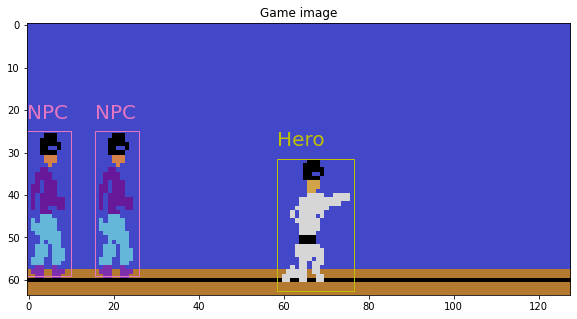

In [ ]:
for i in range(10): 
  n_state, reward, done, info = env.step(env.action_space.sample())
plt.figure(figsize=(15,5))
plt.title('Game image')
render = env.render('rgb_array')[100:164,26:154,:]
plt.imshow(render)
show_npc(render)
show_hero(render)
show_bullet(render)
plt.show()

In [ ]:
import numpy as np
import uuid
from PIL import Image

In [ ]:
!rm -r game
!mkdir -p game/image
!mkdir -p game/label

In [ ]:
def get_label_and_coord(render):
    coord = []
    for func in [show_npc, show_hero, show_bullet]:
        flag, tuples = func(render, show=False)
        if flag: coord+=tuples
    return coord

In [ ]:
from tqdm import trange
env.reset()
for i in range(90): # пропускаем первые тики игры 
    n_state, reward, done, info = env.step(env.action_space.sample())
for j in trange(2000):
    for i in range(np.random.randint(8)):
        n_state, reward, done, info = env.step(env.action_space.sample())
    n_state, reward, done, info = env.step(env.action_space.sample())
    
    if done:
        env.reset()
        for i in range(90): # пропускаем первые тики игры 
            n_state, reward, done, info = env.step(env.action_space.sample())
        continue
    render = env.render('rgb_array')[100:164, 26:154, :]
    list_coord = get_label_and_coord(render)

    im = Image.fromarray(render) # 
    id_i = uuid.uuid4()
    im.save(f"./game/image/{id_i}.png")
    with open(f"./game/label/{id_i}.txt", 'w') as f:
        for coord in list_coord:
            f.write(' '.join(map(str,coord))+'\n')
output.clear()

In [ ]:
!zip -r data.zip ./game

  adding: game/ (stored 0%)
  adding: game/image/ (stored 0%)
  adding: game/image/ccffaa19-e391-49b0-b938-ccd380f3bd86.png (deflated 2%)
  adding: game/image/5c15b1d0-86de-42f7-9d7e-f45d51246c98.png (deflated 5%)
  adding: game/image/8a430bb8-f600-4bde-9510-2f0da715c21e.png (deflated 3%)
  adding: game/image/da3eed28-3420-489c-8e2b-2490c2681d22.png (deflated 2%)
  adding: game/image/5fd7cda8-5325-4791-bc2d-c447828d3d70.png (deflated 6%)
  adding: game/image/204416cd-bf93-46f6-8d8f-0906f63928c7.png (deflated 5%)
  adding: game/image/d0dd44bb-bcb5-46fb-aa33-c1f456181e97.png (deflated 4%)
  adding: game/image/5ca9d6bf-f283-4f17-a2e2-73db88ebee12.png (deflated 3%)
  adding: game/image/5acfd56b-d08a-485b-b02d-34ed8e1839bd.png (deflated 3%)
  adding: game/image/5beca5d7-e07c-4faa-bb5f-8d7d6ff83e9b.png (deflated 3%)
  adding: game/image/eda92ebc-eed3-4e43-957b-f6b47002aa64.png (deflated 7%)
  adding: game/image/16e3c905-03f4-4077-b540-dad617790bd3.png (deflated 3%)
  adding: game/image/46201

In [ ]:
!mkdir new
!unzip -d new/ data.zip

Archive:  data.zip
   creating: new/game/
   creating: new/game/image/
  inflating: new/game/image/ccffaa19-e391-49b0-b938-ccd380f3bd86.png  
  inflating: new/game/image/5c15b1d0-86de-42f7-9d7e-f45d51246c98.png  
  inflating: new/game/image/8a430bb8-f600-4bde-9510-2f0da715c21e.png  
  inflating: new/game/image/da3eed28-3420-489c-8e2b-2490c2681d22.png  
  inflating: new/game/image/5fd7cda8-5325-4791-bc2d-c447828d3d70.png  
  inflating: new/game/image/204416cd-bf93-46f6-8d8f-0906f63928c7.png  
  inflating: new/game/image/d0dd44bb-bcb5-46fb-aa33-c1f456181e97.png  
  inflating: new/game/image/5ca9d6bf-f283-4f17-a2e2-73db88ebee12.png  
  inflating: new/game/image/5acfd56b-d08a-485b-b02d-34ed8e1839bd.png  
  inflating: new/game/image/5beca5d7-e07c-4faa-bb5f-8d7d6ff83e9b.png  
  inflating: new/game/image/eda92ebc-eed3-4e43-957b-f6b47002aa64.png  
  inflating: new/game/image/16e3c905-03f4-4077-b540-dad617790bd3.png  
  inflating: new/game/image/462018f1-7f1d-4587-bed5-c6b465fbc757.png  
  infl